# Práctica 8: Predicción de demanda energética

Inteligencia de Datos

Universidad Iberoamericana Ciudad de México

Creado por: Luis Norberto Zúñiga Morales

El objetivo de esta práctica es usar modelos de aprendizaje automático para realizar predicciones en una serie de tiempo. En este caso, vamos a usar un conjunto de datos que mide la demanda energética de una pequeña comunidad en México. Por supuesto, nosotros queremos construir modelos de aprendizaje que permitan predecir la demanda de energía.

## Conjunto de datos

Vamos a empezar introduciendo el conjunto de datos. Este se puede obtener en la [siguiente liga](https://data.mendeley.com/datasets/vsjtbzjttb/4), y el artículo que acompaña los datos se [encuentra aquí](https://www.sciencedirect.com/science/article/pii/S2352340923010089). Ambos recursos se puden descargar gratuitamente.

**Actividad**: Tomen tiempo para leer el artículo y familiarizarse con el problema y las caraterísticas de los datos. Respondan las siguientes preguntas:

1. ¿Cómo se llama la comunidad dónde se recolectaron los datos?
2. ¿Cuántos conjuntos de datos introduce el artículo?
3. ¿Cuáles son las ventanas de tiempo para la serie de tiempo de la demanda eléctrica y la unidad de medida correspondiente?
4. ¿Cuántas casas fueran considerdas para la obtención de los datos?
5. ¿Cuáles son las limitaciones que los autores mencionan en el artículo?

Para esta práctica, solo vamos a usar los datos de demanda energética de la casa 1 medidos con un intervalo de tiempo de un día. Es decir, deben descargar del repositorio el archivo `houseteh1_1day.csv`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Empezamos cargando los datos en un `DataFrame`de Pandas.

In [2]:
df = pd.read_csv('houseteh1_1day.csv')

Imprimimos los primeros cinco elementos del `DataFrame` para verificar que todo se haya cargado correctamente y observar la estructura de los datos.

In [3]:
df.head()

,Time,kWh
0,21/05/2022 00:00,1.5108
1,22/05/2022 00:00,5.6523
2,23/05/2022 00:00,4.9150
3,24/05/2022 00:00,5.3037
4,25/05/2022 00:00,4.5187


Noten que los datos son muy sencillos. ¿Qué tipos de datos tienen nuestros?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    377 non-null    object 
 1   kWh     377 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.0+ KB


Noten que la columna de tiempo `Time` no se encuentra reprsentada correctamente. Debemos transformarla en un tipo de dato llamado `datetime` para Pandas. Además, vamos a fijar el índice de nuestro `DataFrame` usando la nueva columna de tiempo. Noten el parámetro adicional `dayfirst` que se necesita añadir dada la estructura de las fechas (el primero número es el día).

In [5]:
#convert datetime from object to datetime type
df['Time'] = pd.to_datetime(df['Time'], dayfirst = True)
#set datetime as index
df = df.set_index(df.Time)

#drop datetime column
df.drop('Time', axis=1, inplace=True)

#create hour, day and month variables from datetime index
df['dia'] = df.index.day
df['mes'] = df.index.month
# df['hora'] = df.index.hour

In [ ]:
df.head()

## Análisis básico de series de tiempo

Las series de tiempo se pueden analizar de distintas maneras. En este caso, vamos a realizar una pequeña exploración para medir patrones, en particular de estacionalidad, en los datos. Todo lo vamos a hacer usando la librería `statsmodels`de Python.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [8]:
plt.rcParams['figure.dpi'] = 300

In [9]:
def decompose_time_series(df, sample = 200, period = 24):

  if sample == 'all':
    res = seasonal_decompose(df['kWh'].values, period = period)
  else:
    res = seasonal_decompose(df['kWh'].values[:250], period = period)

  observed = res.observed
  trend = res.trend
  seasonal = res.seasonal

  #plot the complete time series
  fig, axs = plt.subplots(3, figsize=(24,8))
  fig.tight_layout()
  axs[0].set_title('Serie de Tiempo Observada', fontsize=12)
  axs[0].plot(observed)
  axs[0].grid()

  #plot the trend of the time series
  axs[1].set_title('Tendencia', fontsize=12)
  axs[1].plot(trend)
  axs[1].grid()

  #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
  axs[2].set_title('Estacionalidad', fontsize=12)
  axs[2].plot(seasonal)
  axs[2].grid()

  plt.show()

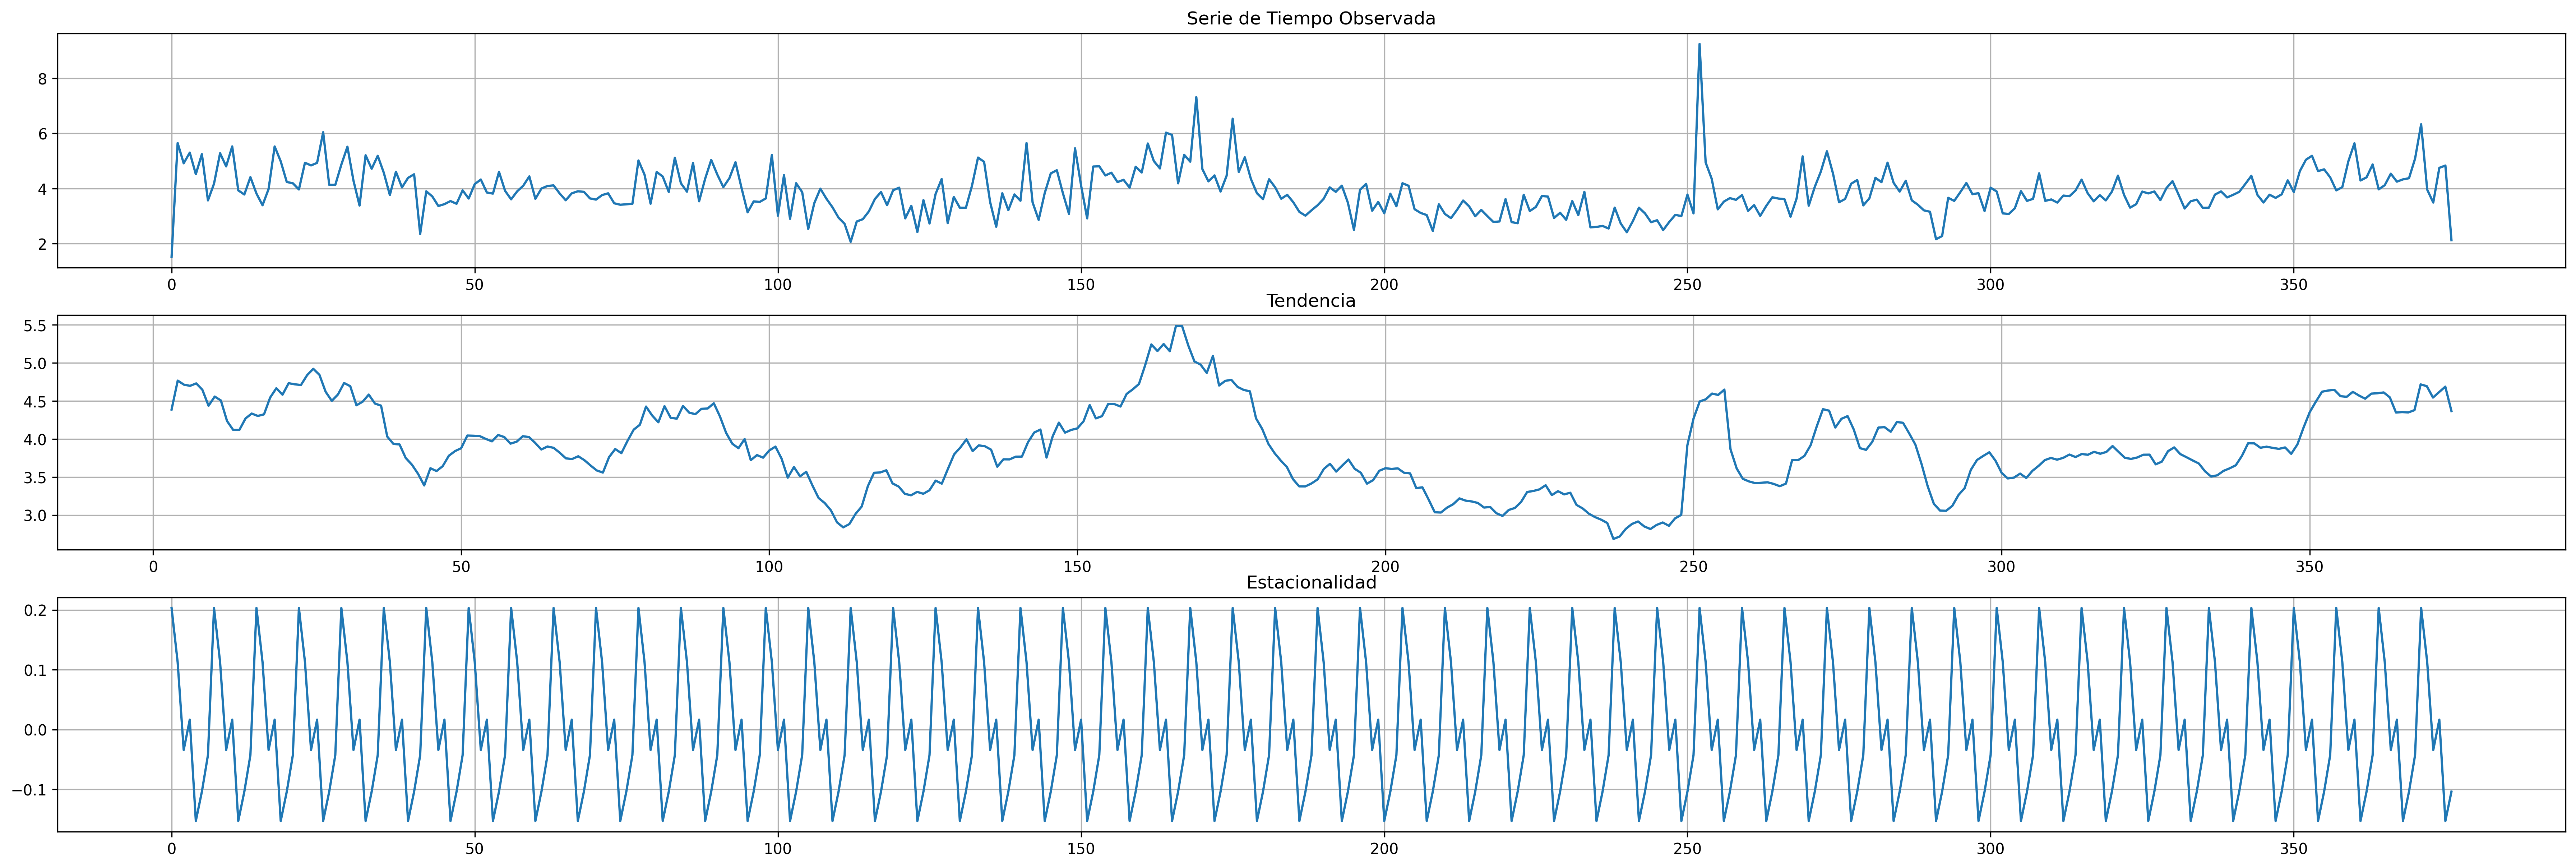

In [10]:
decompose_time_series(df, sample = 'all', period = 7)

**Pregunta**: ¿Qué observan en las gráfica anteriores? Responder en una celda de texto abajo.

## Partición de los datos

In [11]:
X = df.drop('kWh', axis=1)
y = df['kWh']

In [25]:
horizon = 1*30 # un día en el último mes

In [26]:
X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

In [ ]:
print(X_test)

In [ ]:
print(y_test)

### Baseline para comparación: regresión lineal

Vamos a entrenar un modelo base que sirva para comparar el desempeño de los otros modelos. Dado que es un caso de regresión, el modelo base será uno de regresión lineal simple, ya que esperamos que sus predicciones sean malas por su simpleza. A continuación, declaramos el modelo, lo entrenamos con el conjunto de entrenamiento y realizamos las predicciones con el conjunto de prueba.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [17]:
lin_model = LinearRegression()

In [18]:
lin_model.fit(X_train, y_train)

LinearRegression()

In [19]:
lin_model_pred = lin_model.predict(X_test)

In [20]:
lin_model_error = mean_squared_error(y_test, lin_model_pred)
lin_model_error

0.8574291128722433

Definimos la función para graficar las predicciones de un modelo contra los valores correctos.

In [23]:
def plot_predictions(y_test, predictions, model_error):
  #plot reality vs prediction for the last week of the dataset
  fig = plt.figure(figsize=(16,6))
  plt.title(f'Real vs Predicción (ECM {model_error.round(4)})', fontsize=20)
  plt.plot(y_test, color='red')
  plt.plot(pd.Series(predictions, index=y_test.index), color='green')
  plt.xlabel('Tiempo', fontsize=16)
  plt.ylabel('Consumo energético (kWh)', fontsize=16)
  plt.legend(labels=['Real', 'Prediction'], fontsize=16)
  plt.grid()
  plt.show()

Graficamos la predicción que realizó el modelo de regresión lineal contra los valores reales.

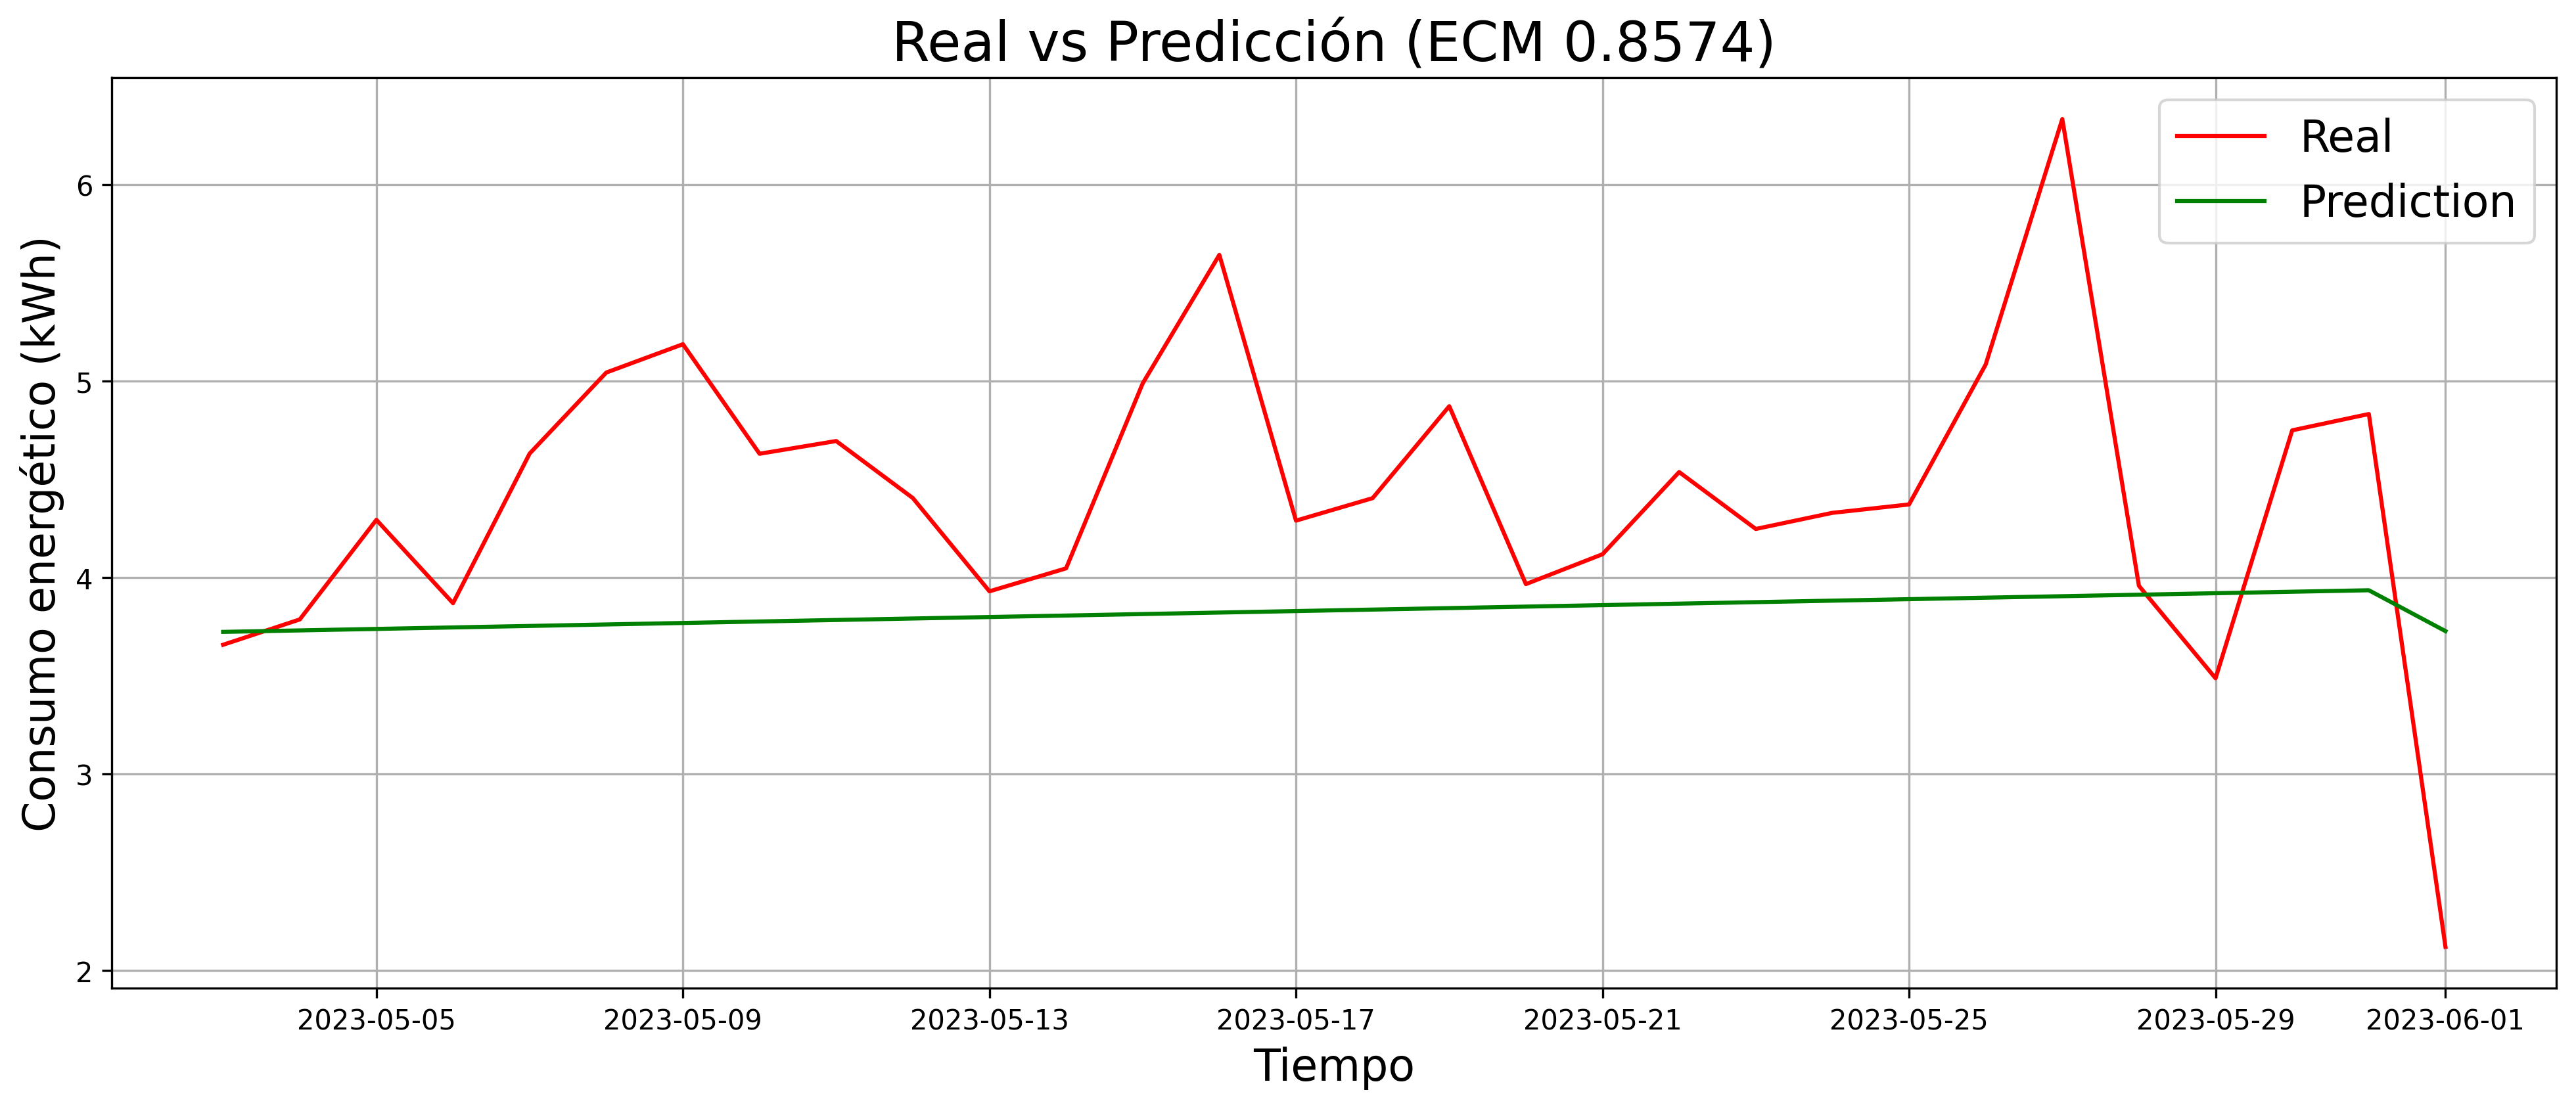

In [24]:
plot_predictions(y_test, lin_model_pred, lin_model_error)

La predicción solo marca una tendencia, que no es tan buen resultado. Vamos (en realidad, *ustedes* van a) explorar si modelos más complejos mejoran las predicciones de la serie de tiempo.

## Actividades

1. Verifiquemos que el modelo de regresión lineal no es buen candidato. Ajusten el modelo con regresión Ridge y Lasso con un modelo de regresión polinomial (propongan el grado). ¿Ayuda la regularización del modelo de regresión lineal?
2. Usen un Árbol de Decisión para regresión y ajústenlo con los datos. Eligan algunos parámetros y optimicen su modelo. Obtengan el ECM.
3. Usen Gradient Boosting para regresión y ajústenlo con los datos. Eligan algunos parámetros y optimicen su modelo. Obtengan el ECM.
4. Usen Bosques Aleatorios para regresión y ajústenlo con los datos. Eligan algunos parámetros y optimicen su modelo. Obtengan el ECM.

Para todos los modelos anteriores, grafiquen la predicción que realiza cada modelo y el valor real. Recuerden usar el mismo conjunto de prueba para determinar los errores de ajuste (ECM).

5. ¿Qué modelo es el mejor según los experimentos?


